In [1]:
import warnings
warnings.filterwarnings("ignore")

## **Gathering, analysing and visualizing the data**

---



In [ ]:
!wget https://www.dropbox.com/s/sakwef33t0jnqj6/CXR_Dataset.zip?dl=0

In [ ]:
!unzip /content/CXR_Dataset.zip?dl=0

Importing the necessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import shutil
import glob

from statistics import mean

import plotly.graph_objects as go
import plotly.express as px

Storing the path of the root directory, a directory named "all_images" where we will copy all the images

In [5]:
ROOT_DIR= "/content/CXR Dataset"
images=["COVID","Normal","Pneumonia"]

NEW_DIR="/content/all_images/"

Copying all the images to the new directory created

In [6]:
if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)

for i in images:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Folder already exists")

Folder already exists


Getting the total count of the different classes of images

In [7]:
counter = {'COVID':0,'Normal':0,'Pneumonia':0}

for image in images:
  for count in glob.iglob(NEW_DIR+image+"*"):
    counter[image] += 1

counter

{'COVID': 3616, 'Normal': 3583, 'Pneumonia': 3875}

Visualizing the image count

In [8]:
df = pd.DataFrame()
df['Illness'] = counter.keys()
df['Count'] = counter.values()

In [26]:
fig = px.bar(df, x = 'Illness', y = 'Count', 
             color = "Illness",  width = 600, 
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)
fig.update_layout(title = "CATEGORICAL IMAGE COUNT", template="simple_white")

fig.show()

## **Data Splitting**

---



First, we create a sub-directory within 'all_images' where we split the data 
into 3 sets: Training data, Testing data and Validation Data.

As we saw in the last section, we have different image counts for the different classes. So the data distribution is non-uniform. 

The division of images is as follows:

Training data contains 1500 samples from each class

Testing data contains 1000 samples from each class

Validation data contains 900 samples from each class

In [ ]:
if not os.path.exists(NEW_DIR+"train_test_split/"):
  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/COVID")
  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/Pneumonia")

  os.makedirs(NEW_DIR+"train_test_split/test/COVID")
  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/Pneumonia")

  os.makedirs(NEW_DIR+"train_test_split/validation/COVID")
  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/Pneumonia")

  # Training Data
  for i in np.random.choice(replace= False , size= 1500 , a = glob.glob(NEW_DIR+images[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 1500 , a = glob.glob(NEW_DIR+images[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 1500 , a = glob.glob(NEW_DIR+images[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Pneumonia" )
    os.remove(i)




 # Validation Data
  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+images[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+images[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+images[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Pneumonia" )
    os.remove(i)


 
 # Test Data
  for i in np.random.choice(replace= False , size= 1000 , a = glob.glob(NEW_DIR+images[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 1000 , a = glob.glob(NEW_DIR+images[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 1000 , a = glob.glob(NEW_DIR+images[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Pneumonia" )
    os.remove(i)


Storing the paths of the directories in which we splitted the data into 3 variables

In [ ]:
train_path  = "/content/all_images/train_test_split/train"
valid_path  = "/content/all_images/train_test_split/validation"
test_path   = "/content/all_images/train_test_split/test"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import keras

from keras.layers import *

Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation. We will be using this class for all 3 types of data.

For training our model, we will be including some augmentations like zooming, horizontal flipping, shearing, vertical and horizontal shifts such that the model is trained on all forms of image data.

## **Training the pre-trained ResNet50 model with our data**

---



In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen_res = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1
                                    )

train_res = train_datagen_res.flow_from_directory(directory= train_path,
                                              target_size=(224,224),
                                              class_mode='categorical'
                                              )

Found 4500 images belonging to 3 classes.


In [ ]:
validation_datagen_res = ImageDataGenerator(preprocessing_function= preprocess_input)

valid_res = validation_datagen_res.flow_from_directory(directory= valid_path,
                                                    target_size=(224,224),
                                                    class_mode='categorical'
                                              )

Found 2700 images belonging to 3 classes.


In [ ]:
test_data_gen = ImageDataGenerator(preprocessing_function= preprocess_input )

test_res = test_data_gen.flow_from_directory(directory= test_path,
                                              target_size=(224,224),
                                              shuffle= False,
                                              class_mode='categorical'
                                              )

Found 3000 images belonging to 3 classes.


In [ ]:
class_type = {0:'COVID',  1:'Normal', 2:'Pneumonia'}

We won't include the fully connected layer at the top. So, we set the respective parameter to false.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

res = ResNet50( input_shape=(224,224,3), include_top= False)

94765736/94765736 [==============================] - 5s 0us/step


Since ResNet50 is a pre-trained model, we won't train the parameters again

In [ ]:
for layer in res.layers:           
  layer.trainable = False

In [ ]:
x = GlobalMaxPooling2D(name = 'max_pool')(res.output)
x = BatchNormalization()(x)

x = Dense(units = 3, activation = 'softmax', name = 'dense')(x)

model = Model(res.input, x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
resnet = Model(inputs = res.input, outputs = x)

The compile method configures the model for training.

In [ ]:
resnet.compile( optimizer= 'adam' , loss = 'categorical_crossentropy', metrics=['accuracy'])

Training the model with suitable parameters. Here, we train the model for 20 epochs.

In [ ]:
resnet_fit = resnet.fit(train_res, steps_per_epoch= 140, epochs= 20, validation_data= valid_res)

Epoch 1/20
140/140 [==============================] - 80s 493ms/step - loss: 0.4029 - accuracy: 0.8536 - val_loss: 0.3454 - val_accuracy: 0.8741
Epoch 2/20
140/140 [==============================] - 66s 471ms/step - loss: 0.2449 - accuracy: 0.9103 - val_loss: 0.1855 - val_accuracy: 0.9333
Epoch 3/20
140/140 [==============================] - 68s 488ms/step - loss: 0.2100 - accuracy: 0.9226 - val_loss: 0.2256 - val_accuracy: 0.9215
Epoch 4/20
140/140 [==============================] - 67s 482ms/step - loss: 0.1768 - accuracy: 0.9322 - val_loss: 0.1763 - val_accuracy: 0.9378
Epoch 5/20
140/140 [==============================] - 68s 486ms/step - loss: 0.1691 - accuracy: 0.9369 - val_loss: 0.1946 - val_accuracy: 0.9248
Epoch 6/20
140/140 [==============================] - 67s 479ms/step - loss: 0.1608 - accuracy: 0.9423 - val_loss: 0.1725 - val_accuracy: 0.9341
Epoch 7/20
140/140 [==============================] - 67s 477ms/step - loss: 0.1813 - accuracy: 0.9331 - val_loss: 0.1693 - val_ac

In [ ]:
resnet_hist = resnet_fit.history

In [ ]:
resnet_hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

We calculate the mean values of the Training and Validation Accuracy and Loss for later use

In [ ]:
training_accuracy_resnet = mean(resnet_hist['accuracy'])
training_loss_resnet = mean(resnet_hist['loss'])

validation_accuracy_resnet = mean(resnet_hist['val_accuracy'])
validation_loss_resnet = mean(resnet_hist['val_loss'])

Plotting the Accuracy and Losses epoch-wise graph for visualization

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,21)), y=resnet_hist['accuracy'], name="Training Accuracy"))
fig.add_trace(go.Scatter(x=list(range(1,21)), y=resnet_hist['val_accuracy'], name="Validation Accuracy"))

fig.update_layout(title="ACCURACY OF RESNET-50", xaxis_title="Epochs", yaxis_title="Accuracy", xaxis=dict(tickmode = 'linear', tick0 = 1, dtick = 1), 
                  width=800, height=600, template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,21)), y=resnet_hist['loss'], name="Training Loss"))
fig.add_trace(go.Scatter(x=list(range(1,21)), y=resnet_hist['val_loss'], name="Validation Loss"))

fig.update_layout(title="LOSSES ENCOUNTERED BY RESNET-50", xaxis_title="Epochs", yaxis_title="Loss",xaxis=dict(tickmode = 'linear', tick0 = 1, dtick = 1),
                  width=800, height=600, template="plotly_white")
fig.show()

##**Custom Model (PneuCoNet)**

---



In [ ]:
train_datagen_pneuco = ImageDataGenerator(rescale=1./255,
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1
                                          )

train_pneuco = train_datagen_pneuco.flow_from_directory(directory= train_path, 
                                              target_size=(224,224),
                                              class_mode='categorical'
                                           )

Found 4500 images belonging to 3 classes.


In [ ]:
validation_datagen_pneuco = ImageDataGenerator(rescale= 1./255)

valid_pneuco = validation_datagen_pneuco.flow_from_directory(directory= valid_path, 
                                                    target_size=(224,224),
                                                    class_mode='categorical'
                                                )

Found 2700 images belonging to 3 classes.


In [ ]:
test_datagen_pneuco = ImageDataGenerator(rescale= 1./255)

test_pneuco = test_datagen_pneuco.flow_from_directory(directory= test_path , 
                                              target_size=(224,224),
                                              shuffle= False,
                                              class_mode='categorical')

Found 3000 images belonging to 3 classes.


Creating our own Sequential model using deep learning layers

In [ ]:
pneuconet = keras.Sequential()

pneuconet.add(Input(shape=(224,224,3)))
pneuconet.add(Conv2D(32, (3, 3), activation="relu", padding='same', name = 'block1_conv1'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block1_pool1'))
pneuconet.add(Conv2D(32, (3, 3), activation="relu", padding='same', name = 'block1_conv2'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block1_pool2'))

pneuconet.add(Conv2D(64, (3, 3), activation="relu", padding='same', name = 'block2_conv1'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block2_pool1'))
pneuconet.add(Conv2D(64, (3, 3), activation="relu", padding='same', name = 'block2_conv2'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block2_pool2'))

pneuconet.add(Conv2D(128, (3, 3), activation="relu", padding='same', name = 'block3_conv1'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block3_pool1'))
pneuconet.add(Conv2D(128, (3, 3), activation="relu", padding='same', name = 'block3_conv2'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block3_pool2'))

pneuconet.add(Conv2D(256, (3, 3), activation="relu", padding='same', name = 'block4_conv'))
pneuconet.add(MaxPooling2D(pool_size = (2, 2), name = 'block4_pool'))

pneuconet.add(Flatten())

pneuconet.add(Dense(128, activation="relu"))
pneuconet.add(Dense(64, activation="relu"))
pneuconet.add(Dense(3, activation="softmax", name = 'predictions'))

In [ ]:
pneuconet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 32)      896       
                                                                 
 block1_pool1 (MaxPooling2D)  (None, 112, 112, 32)     0         
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 32)      9248      
                                                                 
 block1_pool2 (MaxPooling2D)  (None, 56, 56, 32)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 64)        18496     
                                                                 
 block2_pool1 (MaxPooling2D)  (None, 28, 28, 64)       0         
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 28, 64)        3

In [ ]:
#!pip install visualkeras

In [ ]:
#from matplotlib.ticker import scale_range
#import visualkeras


#visualkeras.layered_view(pneuconet,to_file="Visual.png", legend=True, spacing= 15)

In [ ]:
pneuconet.compile( optimizer= 'adam' , loss = 'categorical_crossentropy', metrics=['accuracy'])

Training our custom model with the same parameters used for training the ResNet50 model

In [ ]:
pneuco_fit = pneuconet.fit(train_pneuco, steps_per_epoch= 140, epochs= 20, validation_data= valid_pneuco)

Epoch 1/20
140/140 [==============================] - 64s 442ms/step - loss: 0.9070 - accuracy: 0.5338 - val_loss: 0.5734 - val_accuracy: 0.7878
Epoch 2/20
140/140 [==============================] - 62s 441ms/step - loss: 0.5606 - accuracy: 0.7775 - val_loss: 0.5039 - val_accuracy: 0.8063
Epoch 3/20
140/140 [==============================] - 61s 433ms/step - loss: 0.4496 - accuracy: 0.8256 - val_loss: 0.4179 - val_accuracy: 0.8485
Epoch 4/20
140/140 [==============================] - 61s 439ms/step - loss: 0.4126 - accuracy: 0.8422 - val_loss: 0.3625 - val_accuracy: 0.8678
Epoch 5/20
140/140 [==============================] - 60s 431ms/step - loss: 0.3752 - accuracy: 0.8516 - val_loss: 0.3219 - val_accuracy: 0.8915
Epoch 6/20
140/140 [==============================] - 61s 437ms/step - loss: 0.3512 - accuracy: 0.8574 - val_loss: 0.3086 - val_accuracy: 0.8867
Epoch 7/20
140/140 [==============================] - 60s 431ms/step - loss: 0.3126 - accuracy: 0.8749 - val_loss: 0.2704 - val_ac

In [ ]:
pneuco_hist = pneuco_fit.history

In [ ]:
training_accuracy_pneuconet = mean(pneuco_hist['accuracy'])
training_loss_pneuconet = mean(pneuco_hist['loss'])

validation_accuracy_pneuconet = mean(pneuco_hist['val_accuracy'])
validation_loss_pneuconet = mean(pneuco_hist['val_loss'])

Plotting the Accuracy and Loss epoch-wise graphs

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,21)), y=pneuco_hist['accuracy'], name="Training Accuracy"))
fig.add_trace(go.Scatter(x=list(range(1,21)), y=pneuco_hist['val_accuracy'], name="Validation Accuracy"))

fig.update_layout(title="ACCURACY OF PNEUCONET", xaxis_title="Epochs", yaxis_title="Accuracy", xaxis=dict(tickmode = 'linear', tick0 = 1, dtick = 1),
                  width=800, height=600, template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,21)), y=pneuco_hist['loss'], name="Training Loss"))
fig.add_trace(go.Scatter(x=list(range(1,21)), y=pneuco_hist['val_loss'], name="Validation Loss"))

fig.update_layout(title="LOSSES ENCOUNTERED BY PNEUCONET", xaxis_title="Epochs", yaxis_title="Loss", xaxis=dict(tickmode = 'linear', tick0 = 1, dtick = 1),
                  width=800, height=600, template="plotly_white")
fig.show()

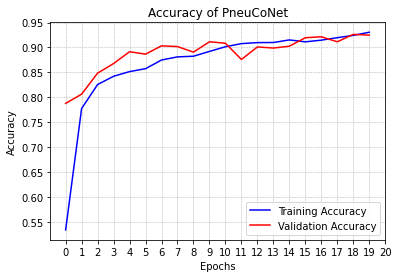

In [ ]:
plt.plot(pneuco_hist['accuracy'],'b-', label='Training Accuracy')
plt.plot(pneuco_hist['val_accuracy'] ,'r-',label='Validation Accuracy')
plt.title("Accuracy of PneuCoNet")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.xticks(range(0,21))
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

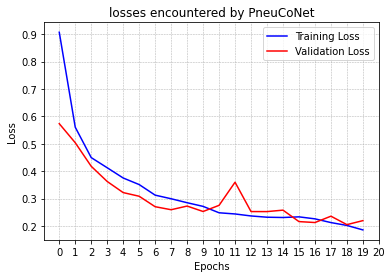

In [ ]:
plt.plot(pneuco_hist['loss'],'b-', label='Training Loss')
plt.plot(pneuco_hist['val_loss'] ,'r-',label='Validation Loss')
plt.title("Losses encountered by PneuCoNet")

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(range(0,21))
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
#from keras.utils import plot_model

#architecture = plot_model(pneuconet, to_file="Pneuconet.png", show_shapes=True, show_layer_names=True)

In [ ]:
#'''from keras.models import load_model
#pneuconet.save('pneuconet.h5')

## **Training the pre-trained DenseNet121 model with our data**

---



In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

dense = DenseNet121( input_shape=(224,224,3), include_top= False)

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen_dense = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1
                                    )

train_dense = train_datagen_dense.flow_from_directory(directory= train_path, 
                                           target_size=(224,224),
                                           class_mode='categorical'
                                           )

Found 4500 images belonging to 3 classes.


In [ ]:
validation_datagen_dense = ImageDataGenerator(preprocessing_function= preprocess_input)

valid_dense = validation_datagen_dense.flow_from_directory(directory= valid_path, 
                                                target_size=(224,224),
                                                class_mode='categorical'
                                                )

Found 2700 images belonging to 3 classes.


In [ ]:
test_datagen_dense = ImageDataGenerator(preprocessing_function= preprocess_input)

test_dense = test_datagen_dense.flow_from_directory(directory= test_path , 
                                          target_size=(224,224), 
                                          shuffle= False,
                                          class_mode='categorical')

Found 3000 images belonging to 3 classes.


In [ ]:
for layer in dense.layers:           
  layer.trainable = False

In [ ]:
x3 = GlobalMaxPooling2D(name = 'max_pool')(dense.output)
x3 = BatchNormalization()(x3)

x3 = Dense(units = 3, activation = 'softmax', name = 'dense')(x3)

model2 = Model(dense.input, x3)

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
model2 = Model(inputs = dense.input, outputs = x3)

In [ ]:
model2.compile( optimizer= 'adam' , loss = 'categorical_crossentropy', metrics=['accuracy'])

Training the pre-trained model with our data

In [ ]:
dense_fit = model2.fit(train_dense, steps_per_epoch= 140, epochs= 20, validation_data= valid_dense)

Epoch 1/20
140/140 [==============================] - 91s 599ms/step - loss: 0.4440 - accuracy: 0.8209 - val_loss: 0.3202 - val_accuracy: 0.8748
Epoch 2/20
140/140 [==============================] - 70s 498ms/step - loss: 0.2709 - accuracy: 0.8966 - val_loss: 0.2486 - val_accuracy: 0.9052
Epoch 3/20
140/140 [==============================] - 67s 479ms/step - loss: 0.2425 - accuracy: 0.9076 - val_loss: 0.2360 - val_accuracy: 0.9063
Epoch 4/20
140/140 [==============================] - 66s 471ms/step - loss: 0.2201 - accuracy: 0.9127 - val_loss: 0.2287 - val_accuracy: 0.9100
Epoch 5/20
140/140 [==============================] - 67s 476ms/step - loss: 0.2048 - accuracy: 0.9230 - val_loss: 0.1856 - val_accuracy: 0.9263
Epoch 6/20
140/140 [==============================] - 66s 470ms/step - loss: 0.2012 - accuracy: 0.9252 - val_loss: 0.1961 - val_accuracy: 0.9222
Epoch 7/20
140/140 [==============================] - 65s 465ms/step - loss: 0.1919 - accuracy: 0.9264 - val_loss: 0.2382 - val_ac

In [ ]:
dense_hist = dense_fit.history

In [ ]:
training_accuracy_dense = mean(dense_hist['accuracy'])
training_loss_dense = mean(dense_hist['loss'])

validation_accuracy_dense = mean(dense_hist['val_accuracy'])
validation_loss_dense = mean(dense_hist['val_loss'])

Plotting the graphs epoch-wise

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,21)), y=dense_hist['accuracy'], name="Training Accuracy"))
fig.add_trace(go.Scatter(x=list(range(1,21)), y=dense_hist['val_accuracy'], name="Validation Accuracy"))

fig.update_layout(title="ACCURACY OF DENSENET-121", xaxis_title="Epochs", yaxis_title="Accuracy", xaxis=dict(tickmode = 'linear', tick0 = 1, dtick = 1),
                  width=800, height=600, template="plotly_white")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,21)), y=dense_hist['loss'], name="Training Loss"))
fig.add_trace(go.Scatter(x=list(range(1,21)), y=dense_hist['val_loss'], name="Validation Loss"))

fig.update_layout(title="LOSSES ENCOUNTERED BY DENSENET-121", xaxis_title="Epochs", yaxis_title="Loss", xaxis=dict(tickmode = 'linear', tick0 = 1, dtick = 1), 
                  width=800, height=600, template="plotly_white")
fig.show()

##**Comparing Model Stats**

---



In [ ]:
model_comp = pd.DataFrame({"Models":['PneuCoNet','ResNet50','DenseNet121'],
                           "Batch Size":[32,32,32],
                           "Steps per epoch":[140, 140, 140],
                           "Number of epochs":[20,20,20],
                           
                           "Training Accuracy (mean)":[training_accuracy_pneuconet, training_accuracy_resnet, training_accuracy_dense],
                           
                           "Training Loss (mean)":[training_loss_pneuconet, training_loss_resnet, training_loss_dense],
                           
                           "Validation Accuracy (mean)" :[validation_accuracy_pneuconet, validation_accuracy_resnet, validation_accuracy_dense],
                           
                           "Validation Loss (mean)":[validation_loss_pneuconet, validation_loss_resnet, validation_loss_dense]
                            })

model_comp

,Models,Batch Size,Steps per epoch,Number of epochs,Training Accuracy (mean),Training Loss (mean),Validation Accuracy (mean),Validation Loss (mean)
0,PneuCoNet,32,140,20,0.868196,0.323849,0.889333,0.301578
1,ResNet50,32,140,20,0.937690,0.170451,0.934556,0.187305
2,DenseNet121,32,140,20,0.920557,0.207031,0.920037,0.201194


In [ ]:
model_comp.to_csv('Model Comparison.csv', index=False)

##**Model Performance** 

---



In [ ]:
test_accuracy = pneuconet.evaluate(test_pneuco)
print('Accuracy obtained on Testing Set:',test_accuracy[1]*100, '%')

94/94 [==============================] - 9s 100ms/step - loss: 0.2092 - accuracy: 0.9290
Accuracy obtained on Testing Set: 92.90000200271606 %


In [ ]:
test_predict= pneuconet.predict(test_pneuco)

94/94 [==============================] - 9s 94ms/step


In [ ]:
predict_class = np.argmax(test_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
from sklearn.metrics import classification_report

labels = ['COVID', 'Normal', 'Pneumonia']
report = classification_report(test_pneuco.classes, predict_class, target_names=labels, output_dict=True)
print(report)

{'COVID': {'precision': 0.9387550200803213, 'recall': 0.935, 'f1-score': 0.93687374749499, 'support': 1000}, 'Normal': {'precision': 0.8907156673114119, 'recall': 0.921, 'f1-score': 0.9056047197640119, 'support': 1000}, 'Pneumonia': {'precision': 0.9597938144329897, 'recall': 0.931, 'f1-score': 0.9451776649746193, 'support': 1000}, 'accuracy': 0.929, 'macro avg': {'precision': 0.9297548339415743, 'recall': 0.9289999999999999, 'f1-score': 0.9292187107445405, 'support': 3000}, 'weighted avg': {'precision': 0.9297548339415743, 'recall': 0.929, 'f1-score': 0.9292187107445403, 'support': 3000}}


In [ ]:
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Classification Report.csv')

##**Testing on random X-Rays**

---



In [ ]:
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.cm as cm

from IPython.display import Image, display

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = load_img(path, target_size=(224,224,3))
  img = img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

1/1 [==============================] - 0s 75ms/step
The CXR image is of type: Normal



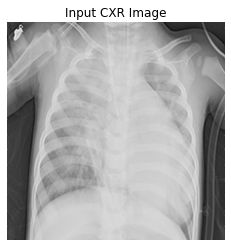

In [ ]:

path = "/content/all_images/train_test_split/test/Pneumonia/Pneumonia (1497).png"       


img = get_img_array(path)

res = class_type[np.argmax(pneuconet.predict(img))]
print(f"The CXR image is of type: {res}")
print()

plt.imshow(img[0]/255, cmap = "gray")
plt.title("Input CXR Image")
plt.axis('off')
plt.show()

##**Generation of Heatmap**

---



In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.png", alpha=0.4):
    """
    img input shoud not be expanded 
    """

    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
def image_prediction_and_visualization(path,last_conv_layer_name = "conv5_block3_3_conv", model = resnet):
  """
  input:  is the image path, name of last convolution layer , model name
  output : returs the predictions and the area that is effected
  """
  
  img_array = get_img_array(path)
  #res = class_type[np.argmax(model.predict(img))]
  #print(f"The given X-Ray image is of type = {res}")
  #print()
  #print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} %")
  #print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} %")


  a = plt.imread(path)
  plt.imshow(a, cmap = "gray")
  plt.title("Original image")
  plt.axis('off')
  plt.show()

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  print()
  plt.title("Heatmap of the CXR sample")
  plt.imshow(heatmap)
  plt.axis('off')
  plt.show()
  print()
  img = get_img_array(path)

  print()
  print("Heatmap representing infected areas")
  print()

  # function call
  save_and_display_gradcam(path, heatmap)


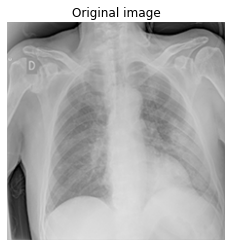

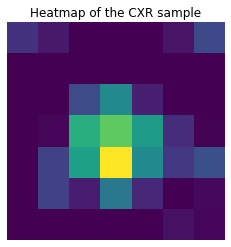



Heatmap representing infected areas



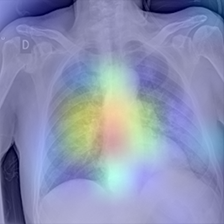

In [ ]:
path = "/content/all_images/train_test_split/test/COVID/COVID-1006.png"

image_prediction_and_visualization(path)